# Hypothesis Testing Phone Plan Revenues

Summary: In this project, a preliminary analysis of two plans offered by Megaline was done on a small client selection (500 Megaline clients) to determine which of the plans brings in more revenue in order to adjust the advertising budget. The data sets were explored, cleaned and merged. Data was visualized for understanding customer behavior in using the services and revenue distribution for the two plans. 

Prompt: The telecom operator Megaline offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget. This is a preliminary analysis of the plans based on a relatively small client selection (500 Megaline clients)

The data for 2018:
* megaline_plans.csv — plans, what is included in each and the cost of exceeding those included services. 
* megaline_users.csv — 500 users, their info and plan, start and end dates
* megaline_calls.csv — calls and duration of calls
* megaline_internet.csv — mb used for each session 
* megaline_messages.csv — messages sent 

**Goal: Determine which plan brings in more monthly revenue and look into the behavior of the clients for messages, calls and internet use.**

In [323]:
# Loading all the libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

# Load and Explore Datasets

In [324]:
# Load the data files into different DataFrames
mg_calls = pd.read_csv('/datasets/megaline_calls.csv')
mg_internet = pd.read_csv('/datasets/megaline_internet.csv')
mg_messages = pd.read_csv('/datasets/megaline_messages.csv')
mg_plans = pd.read_csv('/datasets/megaline_plans.csv')
mg_users = pd.read_csv('/datasets/megaline_users.csv')


In [325]:
# function for getting an overview of datasets
def explore_data(data):
    
    # general/summary information about the DataFrame
    print(data.info())
    
    # sample of data
    display(data.sample(2))
    
    # null and duplicates count for entire dataset
    print(f'Null: {data.isna().sum().sum()}')
    print(f'Duplicates: {data.duplicated().sum()}')
    
    return

## Plans Data

In [326]:
explore_data(mg_plans)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
1,1000,30720,3000,70,7,0.01,0.01,ultimate
0,50,15360,500,20,10,0.03,0.03,surf


Null: 0
Duplicates: 0


The plans dataframe cosists of the features included with the two plans offered at Megaline and the costs. 
* The index for the mg_plans df could be replaced with the 'plan_name' column. 
* All the data types for this df are appropriate. 
* usd_monthly_pay is the base 
* usd_per_gb	usd_per_message	usd_per_minute should be calcuated based on the uses for each client after exceeding the features given with the clients plan. 
* revenue would be the sum of the base and the cost of the exceeding gb, messages and call minutes. 


## Users Data

In [327]:
explore_data(mg_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
321,1321,Karlyn,Jimenez,19,"North Port-Sarasota-Bradenton, FL MSA",2018-05-31,surf,NaN
401,1401,Charmain,Bryant,67,"Richmond, VA MSA",2018-08-24,ultimate,NaN


Null: 466
Duplicates: 0


In [328]:
# what is the timeframe of this dataset?
print(f'Min date: {mg_users.reg_date.min()} \nMax date: {mg_users.reg_date.max()}')

Min date: 2018-01-01 
Max date: 2018-12-31


The data includes user info, their plan, plan start and end date
* Missing values in 'churn_date' column. These are clients that are still with the same service.
* 'reg_date' should be datetype
* looks like the data is for the year 2018

### Preprocess data

In [329]:
## convert 'reg_date' and 'churn_date' columns to type datetime 
mg_users['reg_date'] = pd.to_datetime(mg_users['reg_date'], format='%Y-%m-%d')
mg_users['churn_date'] = pd.to_datetime(mg_users['churn_date'], format='%Y-%m-%d')
mg_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [330]:
# replace the null churn with the max date of december
mg_users.fillna(mg_users.reg_date.max(), inplace =True)
mg_users.isna().sum().sum()

0

In [331]:
# tenure
mg_users['tenure'] = mg_users['churn_date'].dt.month - mg_users['reg_date'].dt.month
mg_users.sample()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,tenure
115,1115,Yevette,Yang,21,"El Paso, TX MSA",2018-11-19,surf,2018-12-31,1


## Calls Dataset

In [332]:
explore_data(mg_calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


,id,user_id,call_date,duration
23579,1087_36,1087,2018-11-27,14.88
50339,1181_721,1181,2018-05-05,9.23


Null: 0
Duplicates: 0


In [333]:
# how many users made calls?
mg_calls.user_id.nunique()

481

mg_calls data consists of all the calls by all 500 members in this analysis.
* Zero Null values.

[ For calls, thh duration in seconds is rounded up for calculating charges by minutes (even if the call lasted just one second, it will be counted as one minute ]
* new column: 'minutes_duration' to calculate revenue on calls  
* 'call_date' needs to be formated to timestamp type.

### Preprocess Data

In [334]:
mg_calls['minutes_duration'] = np.ceil(mg_calls['duration']).astype('int')

In [335]:
# formating the date column to timestamp datatype  
mg_calls['call_date'] = pd.to_datetime(mg_calls['call_date'], format='%Y-%m-%d')

# adding a month column for analyzing data by months of the year
mg_calls['month'] = mg_calls['call_date'].dt.month
mg_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                137735 non-null  object        
 1   user_id           137735 non-null  int64         
 2   call_date         137735 non-null  datetime64[ns]
 3   duration          137735 non-null  float64       
 4   minutes_duration  137735 non-null  int64         
 5   month             137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.3+ MB


In [336]:
mg_calls.sample()

,id,user_id,call_date,duration,minutes_duration,month
90349,1327_274,1327,2018-09-06,24.57,25,9


## Messages Dataset

In [337]:
explore_data(mg_messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


,id,user_id,message_date
74017,1475_151,1475,2018-11-29
64310,1409_12,1409,2018-11-02


Null: 0
Duplicates: 0


In [338]:
# count of users that used messages
mg_messages.user_id.nunique()

402

messages data included all the instance of messages sent by all 500 users
* The types are appropriate 
* message_date should be formated to timestamp type. 
* month column for analysis 

### Preprocess Data

In [339]:
## formating the date column to timestamp datatype 
mg_messages['message_date'] = pd.to_datetime(mg_messages['message_date'], format='%Y-%m-%d')

# month column for analyzing data by months of the year
mg_messages['month'] = mg_messages['message_date'].dt.month
mg_messages.sample(5)

,id,user_id,message_date,month
639,1006_480,1006,2018-12-02,12
20229,1128_198,1128,2018-06-29,6
46541,1316_452,1316,2018-12-14,12
62176,1391_134,1391,2018-12-17,12
10907,1077_178,1077,2018-11-02,11


## Internet Dataset

In [340]:
explore_data(mg_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


,id,user_id,session_date,mb_used
86326,1400_463,1400,2018-07-25,736.69
30525,1140_68,1140,2018-07-10,598.65


Null: 0
Duplicates: 0


In [341]:
# count of users that used internet
mg_internet.user_id.nunique()

489

the internet dataset consists of all the internet sessions of the 500 members
* 'session_date' needs to be formated to timestamp

[ Data Note: For web traffic, individual web sessions are not rounded up. Instead, the total for the month is rounded up. If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.]
* 1 GB = 1024 MB 

### Preprocess data

In [342]:
## formating the date column to timestamp datatype
mg_internet['session_date'] = pd.to_datetime(mg_internet['session_date'], format='%Y-%m-%d')

#  month column for analyzing data by months
mg_internet['month'] = mg_internet['session_date'].dt.month
mg_internet.sample(5)

,id,user_id,session_date,mb_used,month
94397,1440_35,1440,2018-09-17,890.83,9
70983,1331_234,1331,2018-10-09,0.00,10
15354,1069_318,1069,2018-10-05,268.37,10
29363,1134_90,1134,2018-12-21,534.72,12
67812,1316_21,1316,2018-11-12,0.00,11


## Study plan conditions

In [343]:
# plan conditions
display(mg_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


* count of messages 
* sum of MB (1 GB = 1024 megabytes)
* sum of minutes

## Aggregate and Merge Data Per User Per Month

In [344]:
# Sum of minutes per user per month. 
minutes_per_user = mg_calls.groupby(['user_id', 'month'])['minutes_duration'].sum()
minutes_per_user

user_id  month
1000     12       124
1001     8        182
         9        315
         10       393
         11       426
                 ... 
1498     12       339
1499     9        346
         10       385
         11       308
         12       496
Name: minutes_duration, Length: 2258, dtype: int64

In [345]:
# count of messages by each user per month.
messages_per_user = mg_messages.groupby(['user_id', 'month'])['id'].count()
messages_per_user

user_id  month
1000     12       11
1001     8        30
         9        44
         10       53
         11       36
                  ..
1496     9        21
         10       18
         11       13
         12       11
1497     12       50
Name: id, Length: 1806, dtype: int64

In [346]:
# volume of internet traffic used by each user per month. 
internet_per_user = np.ceil(mg_internet.groupby(['user_id', 'month'])['mb_used'].sum())
internet_per_user

user_id  month
1000     12        1902.0
1001     8         6920.0
         9        13315.0
         10       22331.0
         11       18505.0
                   ...   
1498     12       23138.0
1499     9        12985.0
         10       19493.0
         11       16814.0
         12       22060.0
Name: mb_used, Length: 2277, dtype: float64

In [347]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
user_plan_usage = pd.concat([minutes_per_user, messages_per_user, internet_per_user], axis= 'columns').reset_index()
user_plan_usage.columns = ['user_id', 'month', 'call_minutes', 'messages','mb_used']
user_plan_usage

,user_id,month,call_minutes,messages,mb_used
0,1000,12,124.0,11.0,1902.0
1,1001,8,182.0,30.0,6920.0
2,1001,9,315.0,44.0,13315.0
3,1001,10,393.0,53.0,22331.0
4,1001,11,426.0,36.0,18505.0
...,...,...,...,...,...
2288,1498,12,339.0,NaN,23138.0
2289,1499,9,346.0,NaN,12985.0
2290,1499,10,385.0,NaN,19493.0
2291,1499,11,308.0,NaN,16814.0


In [348]:
# fill null with 0
user_plan_usage.fillna(0, inplace=True)

In [349]:
user_plan_usage.user_id.nunique()

490

10 clients did not use the included services. Have they terminated their plan?

In [350]:
# lookign at the users data set of these 10 clients
ten_clients = mg_users[~mg_users['user_id'].isin(user_plan_usage.user_id.tolist())]
ten_clients

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,tenure
25,1025,Jess,Wilkinson,64,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-10-28,ultimate,2018-12-31,2
129,1129,Marin,Bolton,70,"Baton Rouge, LA MSA",2018-11-10,surf,2018-12-27,1
143,1143,Lorina,Stevens,69,"Cincinnati, OH-KY-IN MSA",2018-10-26,surf,2018-12-31,2
269,1269,Irving,Thompson,39,"Dallas-Fort Worth-Arlington, TX MSA",2018-09-13,ultimate,2018-12-15,3
275,1275,Elvie,Velazquez,33,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-11-29,ultimate,2018-12-31,1
307,1307,Kristopher,Lang,28,"Boston-Cambridge-Newton, MA-NH MSA",2018-12-31,surf,2018-12-31,0
319,1319,Eliseo,Carson,21,"Colorado Springs, CO MSA",2018-06-17,surf,2018-12-31,6
378,1378,Mckinley,Clayton,22,"Denver-Aurora-Lakewood, CO MSA",2018-12-17,surf,2018-12-31,0
463,1463,Dinorah,Simmons,30,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-11-27,ultimate,2018-12-31,1
473,1473,Kirk,Velez,61,"Louisville/Jefferson County, KY-IN MSA",2018-12-31,surf,2018-12-31,0


* looks like all of them reamined with the company from their start to the end of decemeber, but they did not use their services. 
* leaving these outliers out of the analysis. 

In [351]:
# merrge on right to keep all users 
user_data = (user_plan_usage
 .merge(mg_users, on='user_id')
 .merge(mg_plans, left_on='plan', right_on='plan_name'))

user_data.sample()

,user_id,month,call_minutes,messages,mb_used,first_name,last_name,age,city,reg_date,...,churn_date,tenure,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
2253,1491,7,463.0,64.0,7834.0,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,...,2018-09-18,5,50,15360,500,20,10,0.03,0.03,surf


In [352]:
user_data.user_id.nunique()

490

# Calculate the monthly revenue for each user


In [353]:
def calculate_revenue(user_data):
    monthly_pay = user_data['usd_monthly_pay']
    extra_messages, extra_minutes, extra_mb = 0, 0, 0
    if user_data['messages'] > user_data['messages_included']:
        extra_messages = user_data['messages'] - user_data['messages_included'] 
    if user_data['call_minutes'] > user_data['minutes_included']:
        extra_minutes = user_data['call_minutes'] - user_data['minutes_included'] 
    if user_data['mb_used'] > user_data['mb_per_month_included']: 
        extra_mb = user_data['mb_used'] - user_data['mb_per_month_included'] 
    
    extra_messages_rev = extra_messages * user_data['usd_per_message']
    extra_minutes_rev = extra_minutes * user_data['usd_per_minute']
    extra_gb_rev = np.ceil(extra_mb/1024) * user_data['usd_per_gb']
    
    revenue = monthly_pay + extra_messages_rev + extra_minutes_rev + extra_gb_rev
    return revenue
        

In [354]:
user_data['revenue'] = user_data.apply(calculate_revenue, axis=1)
user_data.month.astype('int')
user_data.sample(2)

,user_id,month,call_minutes,messages,mb_used,first_name,last_name,age,city,reg_date,...,tenure,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,revenue
984,1083,10,17.0,4.0,2912.0,Lyndia,Acevedo,65,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-26,...,2,50,15360,500,20,10,0.03,0.03,surf,20.0
373,1247,12,496.0,112.0,26552.0,Marion,Singleton,75,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-04-12,...,8,1000,30720,3000,70,7,0.01,0.01,ultimate,70.0


In [355]:
user_data.isna().sum().sum()

0

In [356]:
user_data['month'] = user_data['month'].astype('int')

# Study User behaviour

In [357]:
# class imabalance of plans
user_data.plan.value_counts()

surf        1573
ultimate     720
Name: plan, dtype: int64

<AxesSubplot:xlabel='month'>

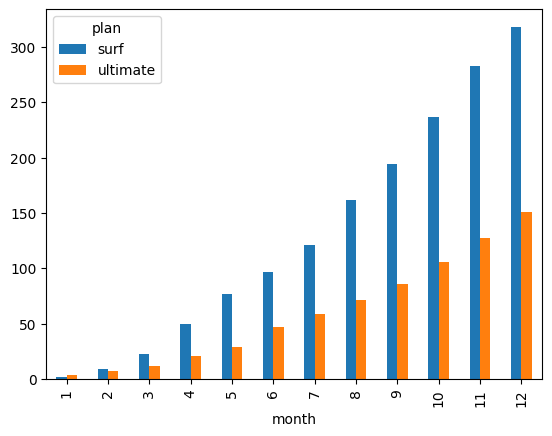

In [368]:
# users by month
count_users_by_month = user_data.groupby(['month', 'plan'])['user_id'].count().unstack()
da.plot(kind='bar')

There is a gradual increase in clients with Megaline from January to decemeber for both plans

## Average Monthly Usage of Services Per Plan 

In [369]:
# Calculate the mean call duration per month and plan
mean_duration = user_data.groupby(['month', 'plan'])['call_minutes', 'messages', 'mb_used'].mean().unstack()
mean_duration.index = mean_duration.index.astype('int')
mean_duration

call_minutes               messages                  mb_used  \
plan          surf    ultimate       surf   ultimate          surf   
month                                                                
1       203.000000  193.500000  10.500000  15.500000   4875.000000   
2       297.000000  403.142857  12.000000  21.571429  12179.444444   
3       330.000000  304.250000  15.260870  20.250000  13345.956522   
4       351.540000  336.857143  17.400000  22.047619  11984.660000   
5       399.584416  406.241379  24.012987  32.103448  13936.857143   
6       431.298969  370.957447  25.298969  29.340426  15302.000000   
7       449.983471  427.067797  27.033058  32.830508  16784.090909   
8       410.111111  421.436620  28.777778  38.478873  16795.820988   
9       414.226804  437.511628  30.762887  37.895349  16591.917526   
10      429.729958  450.735849  33.839662  39.443396  17311.831224   
11      423.325088  445.196850  32.385159  38.606299  16339.749117   
12      473.836478  459.099338  38.600629  45.006623  18132.974843   

                     
plan       ultimate  
month                
1       6918.500000  
2      17129.142857  
3      18322.083333  
4      16122.190476  
5      16624.965517  
6      15338.425532  
7      16345.288136  
8      17815.225352  
9      16970.360465  
10     17613.066038  
11     17034.188976  
12     18323.682119

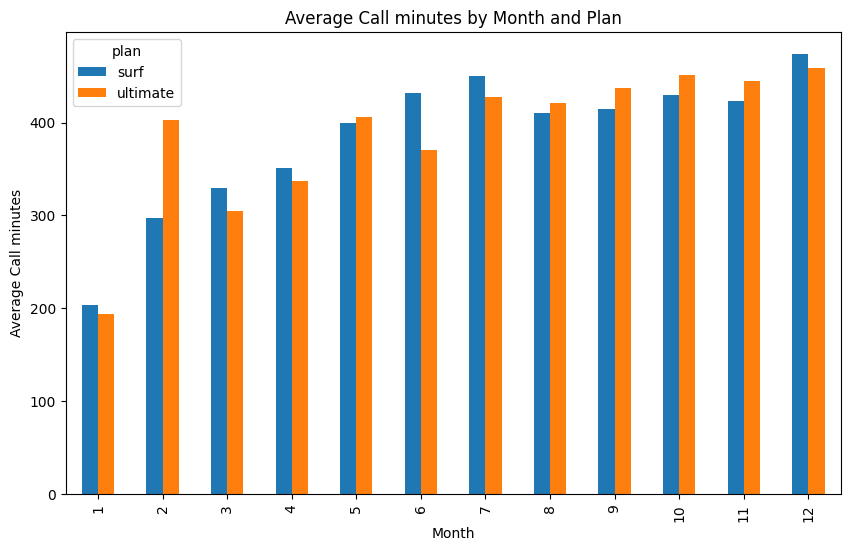

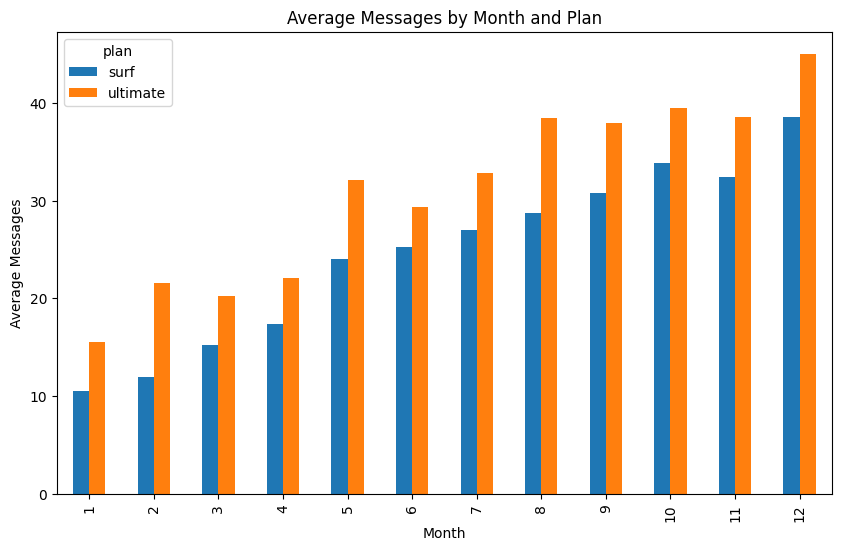

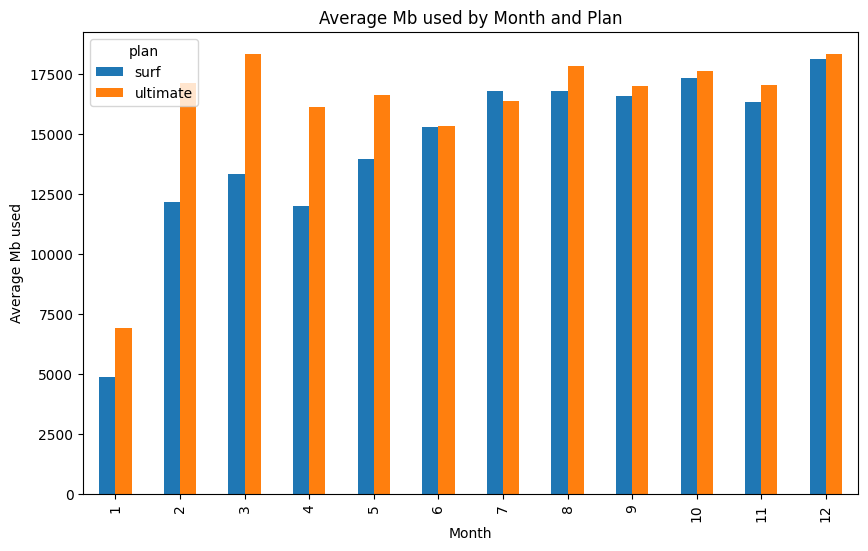

In [370]:
# List of the columns for each metric
metrics = ['call_minutes', 'messages', 'mb_used']

# Loop through each metric and plot
for metric in metrics:
    
    # Plot the surf and ultimate plans for each metric
    mean_duration[metric].plot(kind='bar', title=f'Average {metric.replace("_", " ").capitalize()} by Month and Plan', figsize=(10, 6))
    
    # Set labels
    plt.xlabel('Month')
    plt.ylabel(f'Average {metric.replace("_", " ").capitalize()}')
    
    # Display the plot
    plt.show()


* significantly lower usage of services at the first quarter of the year. to be expected since there was a steady growth in number of users registerign for both plans
* ultimate plan clients have a higher average count of messages. 
* otherwise, the useage is quite similar, could recomending the ultimate plan to surf plan clients increase revenue

### Monthly Distribution of Services Per Plan

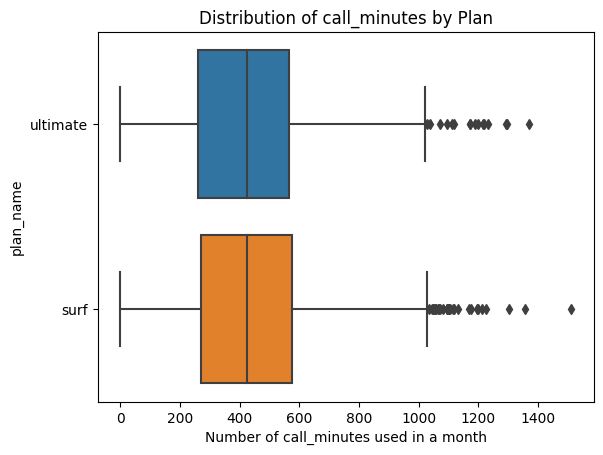

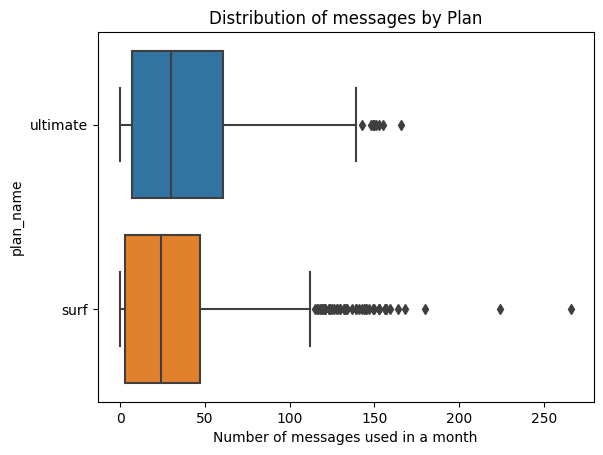

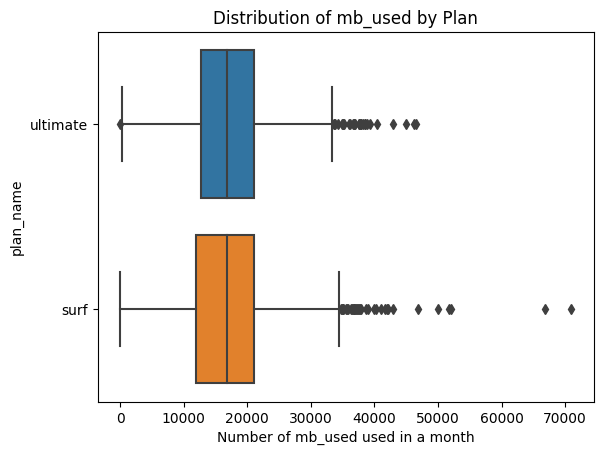

In [371]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['call_minutes', 'messages', 'mb_used']

for metric in metrics:
    # Use seaborn's boxplot with the full user_data DataFrame
    sns.boxplot(x=metric, y='plan_name', data=user_data, orient='h')

    # Set labels and title
    plt.xlabel(f'Number of {metric} used in a month')
    plt.title(f'Distribution of {metric} by Plan')
    plt.show()


Minutes: 
* the distribution of Monthly Minutes used by both Surf and Ultimate plan members is **similar**

Messages:
* The distribution of message counts is **right-skewed** for Ultimate plan members. There is a greater variability in the upper half of the data, with some users sending far more messages than the median.
* Surf: With **Q3 at 50**, **75% of users** have a low message count, indicating that most users fall within a narrow range. but there are a few outliers.

mb_used: 
* Both plans have a **similar distibution**. Monthy internet usage q1 starting at 0, q2 at around 120000 mb, median at 170000, q3 at 220000, and q4 at aprox 350000. there seem to be a few extreme outliers for the Surf plan members 


## Distribution of Monthly Revenue Per Plan

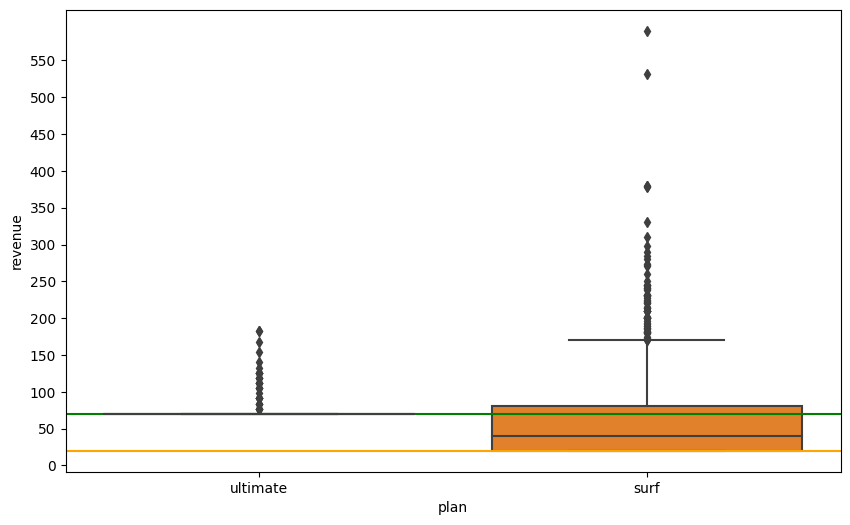

In [373]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.boxplot(x='plan', y='revenue', data=user_data)
plt.yticks(np.arange(0, 600, 50))
plt.axhline(y=70, color='green')
plt.axhline(y=20, color='orange')
plt.show()

* green line: at 70 dollars ( monthy cost of Ultimate plan)
* orange line: at 70 dollars ( monthy cost of Surf plan)
* ultimate: most of the clients returns around 70 dollar monthly. likely due to many clients using their plan without exceeeding the included services. 
* surf: there is greater distribution of returned revenue from surf plan members. Median falls arount 40 dollars. q3 above 70 dollars and q4 at more that 150 dollar. There are also a number of outliers greater than q4. 

* due to the low included services in the surf plan more than 50 percent of the revenue earned from surf plan clients was a result of using more than the limit of services included with the plan. 

It looks like the Surf plan brings in a greater distribution of revenue, more than 25% being higher than the most of the ultimate plan revenue. But this could be a result of the imbalance sample size. 

# Test Statistical Hypotheses

Using a t-test to determine if there is a significant difference between the average revenue of two phone plans (Surf and Ultimate) or if it could have occurred by chance. Determine which plan is returning a higher revenue. 

In [374]:
# monthly revenues for each plan and user
revenue_from_surf_users = user_data[user_data['plan']== 'surf']['revenue']
revenue_from_ultimate_users = user_data[user_data['plan']== 'ultimate']['revenue']

In [375]:
# Test the hypotheses
# H_0 = average revenue from users of the Ultimate and Surf calling plans is equal
# H_1 = average revenue from users of the Ultimate and Surf calling plans differs

# Welch's t-test (equal_var = False for unequal variances) to check for any variance in the imbalanced sample size 
results = st.ttest_ind(revenue_from_surf_users, revenue_from_ultimate_users, equal_var=False)
print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis, ")
else:
    print("We can't reject the null hypothesis")


p-value:  3.1703905481135734e-15
We reject the null hypothesis, 


The p-value tells us there is a difference between the averages of the two plans that is larger than the critical value, therefore we can not reject the null hypothesis.

A bootstrap mean independently resamples from both groups without assuming equal variance or normality. 
* ensures reliable estimates of the mean and confidence intervals, which is important in a case like here where ther is a sample size imbalance. 
* It helps reduce bias and accurately reflects the true variability in each group.

In [376]:
# calculate bootstrap confidence intervals for the mean 
def bootstrap_mean(data, n_bootstrap=10000):
    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(sample.mean())
    return np.percentile(boot_means, [2.5, 97.5])

# Get bootstrap confidence intervals for each plan
surf_bootstrap_ci = bootstrap_mean(revenue_from_surf_users)
ultimate_bootstrap_ci = bootstrap_mean(revenue_from_ultimate_users)

print(f"Surf revenue 95% confidence interval: {surf_bootstrap_ci}")
print(f"Ultimate revenue 95% confidence interval: {ultimate_bootstrap_ci}")


Surf revenue 95% confidence interval: [58.03859011 63.51448172]
Ultimate revenue 95% confidence interval: [71.53611111 73.16944444]


The p-value from our hypothesis test is 3.17e-15, which is an extremely small value (effectively 0). Since this p-value is much smaller than our chosen significance level of 0.05, we can confidently reject the null hypothesis.

This result indicates that the Ultimate and Surf plans are not generating the same average revenue, and this difference is statistically significant. Therefore, any observed revenue disparity between the two plans is unlikely due to chance.

To further understand which plan is returning a higher revenue, bootstrap sampling was used to calculate the 95% confidence intervals for the mean revenue of each plan.

    The 95% confidence interval for the Surf plan’s revenue is [58.03, 63.49].
    The 95% confidence interval for the Ultimate plan’s revenue is [71.55, 73.17].

95% confidence that the true mean revenue for the Surf plan is between 58-64 dollars, and the true mean revenue for the Ultimate plan is between 71-74 dollars.

**Since the confidence intervals do not overlap, this strongly suggests that the average revenue of the Ultimate plan is significantly higher than that of the Surf plan.** The fact that the lowest revenue estimate for the Ultimate plan (71.55) is higher than the highest estimate for the Surf plan (63.49) further supports this conclusion.


# Final Report

1. Datasets was loaded to their respective variables 
2. Datasets were sampled, and checked for missing values and duplicates. data was cleaned and a new dataset consisting of the sum of services per user per month was created and merged with other datasets
3. monthly revenue was calculated for each user per month with their service. 
4. Looked at user behaviors by ploting their monthy usage and revenue
5. Statistical test hypothesis using the t-test and the equal_var parameter set to False to account for any variance as a result of the imbalance data size. Used bootstrap mean confidence intervals for determining which plan produces a higher monthly revenue. 

The t-test resulted in a p-value of **3.17e-15**, significantly lower than the critical value, indicating a statistically significant difference in average revenue between the Surf and Ultimate plans.

Bootstrap confidence intervals show the Surf plan's revenue is between **58.03 and 63.49** dollars, while the Ultimate plan's is between **71.55 and 73.17** dollars. Since the intervals don't overlap, the **Ultimate plan generates significantly higher revenue** than the Surf plan.

From a business perspective, this indicates that the **Ultimate plan is more profitable per user than the Surf plan.** This insight could guide decisions regarding marketing, pricing strategies, or potential adjustments to the Surf plan to increase its revenue performance.

**Further analysis could be done to understand if converting Surf plan members to Ultimate plan members yeilds higher revenue**